In [1]:
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from PIL import Image
from rembg import remove

import tensorflow as tf

import os
import logging

In [2]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s\n%(levelname)s: %(message)s")

## 모델 사용

### 0. 경로 및 환경설정
- 이미지가 저장된 디렉터리 경로 설정

In [3]:
root_path = os.getcwd()
img_path = os.path.join(root_path, "static", "Img")
logging.info(img_path)

2024-10-31 10:29:07,748
INFO: /Users/janghyolim/Desktop/code/HFoot/static/Img


### 1. 이미지 설정
- 저장된 이미지 가져오기<br>1. resize_with_padding( )을 통해 이미지 조정<br/>2. 이미지 형식이 RGBA일 경우 RGB로 수정(A -> alpha, 투명도 처리)
- 모델에서 이미지 처리를 위한 설정
- resize_with_padding<br>1. 이미지크기 조정<br/>2. CNN에서 이미지를 처리할 떄 filter(kernel)가 더 정확하게 스캔할 수 있도록 빈 공간 만들기

In [7]:
def resize_with_padding(image, target_size=(224, 224)):
    h, w = image.shape[:2]
    target_h, target_w = target_size

    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    resized_image = cv2.resize(image, (new_w, new_h))

    pad_w = (target_w - new_w) // 2
    pad_h = (target_h - new_h) // 2

    padded_image = cv2.copyMakeBorder(
        resized_image,
        pad_h,
        target_h - new_h - pad_h,
        pad_w,
        target_w - new_w - pad_w,
        borderType=cv2.BORDER_CONSTANT,
        value=[0, 0, 0],
    )
    
    return padded_image

In [8]:
image = cv2.imread(os.path.join(img_path, "J0085.jpg"))
rb_img = remove(image)
filled = np.array(rb_img)

target_size = (224, 224)
result_image = resize_with_padding(filled, target_size)

if result_image.shape[2] == 4:
    result_image = cv2.cvtColor(result_image, cv2.COLOR_BGRA2BGR)

### 2. 외부 모델 가져오기
- 모델을 불러와 잘 동작하는지 확인합니다(model.summary( ))
- 불러온 이미지도 모델에서 사용할 수 있는 크기로 재조정합니다<br/>1. 이미지 정규화<br/>2. 이미지 차원 변환

In [9]:
model_path = os.path.join(root_path, "static", "keras_model", "cnn_model.keras")
model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        "euclidean_distance_loss": lambda y_true, y_pred: tf.sqrt(
            tf.reduce_sum(tf.square(y_pred - y_true), axis=-1)
        )
    },
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,635,732 (299.97 MB)

 Trainable params: 26,211,910 (99.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,423,822 (199.98 MB)

In [10]:
input_image = result_image / 255.0
input_image = np.expand_dims(input_image, axis=0)

### 3. 모델을 통한 예측
- 모델을 통해 예측한 값을 얻어냅니다
- 이때, 모델은 원본 이미지에서 축소된 224x224인 상태에서 예측을 했기 때문에 다시 원본에 맞는 위치로 변환해줍니다

In [ ]:
predicted_coords = model.predict(input_image)
logging.info(f"예측한 좌표-{predicted_coords}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


2024-10-31 10:48:14,585
INFO: 예측한 좌표: [[127.68803  171.77437  111.69501   15.370489 139.99057   75.47299 ]]


In [12]:
pred_red = (predicted_coords[0][0], predicted_coords[0][1])
pred_green = (predicted_coords[0][2], predicted_coords[0][3])
pred_blue = (predicted_coords[0][4], predicted_coords[0][5])

base_height, base_width = image.shape[:2]
pred_red_x = int(pred_red[0] * base_width / 224)
pred_red_y = int(pred_red[1] * base_height / 224)
pred_green_x = int(pred_green[0] * base_width / 224)
pred_green_y = int(pred_green[1] * base_height / 224)
pred_blue_x = int(pred_blue[0] * base_width / 224)
pred_blue_y = int(pred_blue[1] * base_height / 224)

pred_red = (pred_red_x, pred_red_y)
pred_green = (pred_green_x, pred_green_y)
pred_blue = (pred_blue_x, pred_blue_y)

logging.info(f"변환한 좌표(RGB) - {pred_red} {pred_green} {pred_blue}")

2024-10-31 10:57:38,606
INFO: 변환한 좌표(RGB) - (1710, 3067) (1495, 274) (1874, 1347)


### 4. 각도 계산
- get_angle( )<br/>1. 점들의 좌표를 받아 각도를 계산합니다<br/>2. 역삼각함수를 통해 계산합니다(arccos)

In [13]:
def get_angle(p1, p2, p3):
    a = np.linalg.norm(np.array(p2) - np.array(p1))
    b = np.linalg.norm(np.array(p2) - np.array(p3))
    c = np.linalg.norm(np.array(p1) - np.array(p3))
    
    angle = np.arccos((a**2 + b**2 - c**2) / (2*a*b))
    return np.degrees(angle)

In [15]:
angle = get_angle(pred_red, pred_green, pred_blue)
logging.info(f"계산한 각도 - {angle: .3f}")

2024-10-31 11:01:19,341
INFO: 계산한 각도 -  15.052


### 원본에 예측한 점을 포함한 이미지 출력
- 예측한 점의 좌표를 얻었으므로, 결과사진을 그려냅니다
- pyplot을 이용하고 있는 이유<br>cv2를 ipynb에서 사용하게 되면 간혹 실행하다 중지될 수도 있음

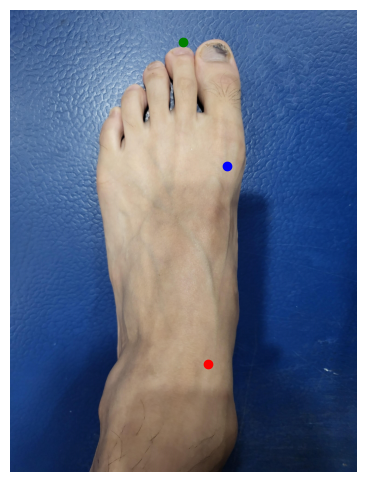

In [18]:
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.scatter(pred_red[0], pred_red[1], color="red")
plt.scatter(pred_green[0], pred_green[1], color="green")
plt.scatter(pred_blue[0], pred_blue[1], color="blue")

plt.axis("off")
plt.show()